# DAT 203 - Lab Assignment #5

- Author: Colin Bowers
- Date: Jun 10, 2023

**Instructions**
1. Upload Titanic dataset 
1. Repeat Assignment 4 
1. Use GridSearchCV to fit the logistic regression with a dictionary of values for C.
1. See what is the best value for the Hyperparameter when using the accuracy score?
1. Investigate the difference between L1 and L2 for the outcome. Is there a difference?
1. Investigate the results of using different cross validation values 
1. For the different investigation procedures, plot the accuracy outcome compared to the different parameters. For example, Accuracy VS. the value of C. 
1. Use Accuracy, Sensitivity, and F1-score to assess the final performance of the chosen model.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk 

**1. Upload Titanic dataset**

In [2]:
df = pd.read_csv("data/Titanic_original.csv")
##df.describe(include="all").round(2)
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
691,692,1,3,"Karun, Miss. Manca",female,4.0,0,1,349256,13.4167,NaN,C
801,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S


**2. Repeat Assignment 4**

In [3]:
target = 'Survived'
predictors = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']

In [4]:
# To reduce column count, let's use PassengerId as the index
df.set_index("PassengerId", inplace=True)

# Logistic Regression requires numeric variables so we should drop these
df.drop('Name', axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
df.drop('Cabin', axis=1, inplace=True)

In [5]:
mode = df["Age"].mode()[0]
df.fillna({'Age': mode}, inplace=True)

In [6]:
dummies = ['Embarked', 'Sex']
for d in dummies:
    df[d] = df[d].astype('category')

dummy_data = pd.get_dummies(df[dummies])
df2 = pd.concat([df, dummy_data], axis=1)
df2.drop(dummies, axis=1, inplace=True)

In [7]:
predictors.remove("Embarked")
predictors.remove("Sex")
predictors += ["Embarked_C", "Embarked_Q", "Embarked_S", "Sex_female", "Sex_male" ]

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.2)

In [9]:
from sklearn.linear_model import LogisticRegression

X_train = train[predictors]
y_train = train[target]

#model = LogisticRegression(solver='lbfgs', max_iter=500)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

model.coef_

array([[-0.97564481, -0.03472686, -0.24131052, -0.13275864,  0.00295706,
         0.6958262 ,  0.4604271 ,  0.24658687,  2.19820898, -0.41858821]])

**3. Use GridSearchCV to fit the logistic regression with a dictionary of values for C.**

In [10]:
%%time
from sklearn.model_selection import GridSearchCV

params_C = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]

params = {
    "C": params_C,
    #"penalty": ["l1", "l2"]
}

gscv = GridSearchCV(
    model,
    params,
    cv=5,
    scoring='accuracy'
)

gscv.fit(X_train, y_train)
print("-----")
print(f'Best parameters {gscv.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{gscv.best_score_:.3f}'
)
print("-----")

-----
Best parameters {'C': 0.75}
Mean cross-validated accuracy score of the best_estimator: 0.809
-----
CPU times: user 379 ms, sys: 0 ns, total: 379 ms
Wall time: 366 ms


In [11]:
gscv.cv_results_

{'mean_fit_time': array([0.00828295, 0.00556107, 0.00563698, 0.00691514, 0.00629163,
        0.00602636, 0.00610304]),
 'std_fit_time': array([0.00195177, 0.00024908, 0.00024614, 0.00029469, 0.00036083,
        0.00034558, 0.00019666]),
 'mean_score_time': array([0.00444326, 0.00276384, 0.00305934, 0.0026063 , 0.00284858,
        0.00259099, 0.00252452]),
 'std_score_time': array([7.36186209e-04, 3.99614592e-04, 4.11185543e-04, 5.39670552e-05,
        3.06297357e-04, 1.19552462e-04, 1.21935532e-04]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 0.25},
  {'C': 0.5},
  {'C': 0.75},
  {'C': 1.0}],
 'split0_test_score': array([0.70629371, 0.75524476, 0.81118881, 0.83216783, 0.83216783,
        0.81818182, 0.81818182]),
 'split1_test_score': array([0.68531469, 0.72027972, 0.7972028 

**4. See what is the best value for the Hyperparameter when using the accuracy score?**

In [12]:
gscv.best_params_

{'C': 0.75}

**5. Investigate the difference between L1 and L2 for the outcome. Is there a difference?**

**6. Investigate the results of using different cross validation values**

**7. For the different investigation procedures, plot the accuracy outcome compared to the different parameters. For example, Accuracy VS. the value of C.**

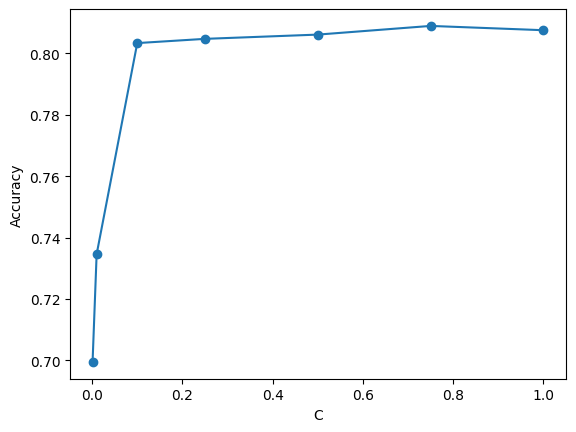

In [13]:
plt.plot(params_C, gscv.cv_results_['mean_test_score'], "-o")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.show()

**8. Use Accuracy, Sensitivity, and F1-score to assess the final performance of the chosen model.**

In [14]:
X_test = test[predictors]
y_test = test[target]

y_pred = gscv.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1])

In [15]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score

In [16]:
confusion_matrix(y_pred, y_test)

array([[94, 25],
       [13, 47]])

In [17]:
acc = accuracy_score(y_pred, y_test)
prec = precision_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Accuracy: 78.77%
Precision: 65.28%
F1 Score: 71.21%
